In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys

In [2]:
os.chdir('/Users/ShivamDhall/Desktop/Project/Dataset/TRIO_data/')

Try loading a niFti dataset of a single patient (single scan)

In [3]:
os.chdir('./Subj10Scan1/')

In [4]:
img = nib.load("NODDI_3Shells.nii.gz")
data = img.get_data()

In [5]:
#get the dimestions of the dataset
print(data.shape)

(96, 96, 55, 117)


In [6]:
#get the size/dimensions of each voxel
print(img.header.get_zooms()[:3])

(2.5, 2.5, 2.5)


Try visualizing the dataset using matplotlib. For example, let’s show the middle axial slices of volume 0 and volume 10.

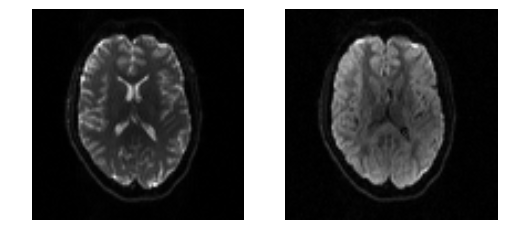

In [7]:
axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()

Try visualising the data at the intersection of a voxel e.g (x=40,y=40,z=20)

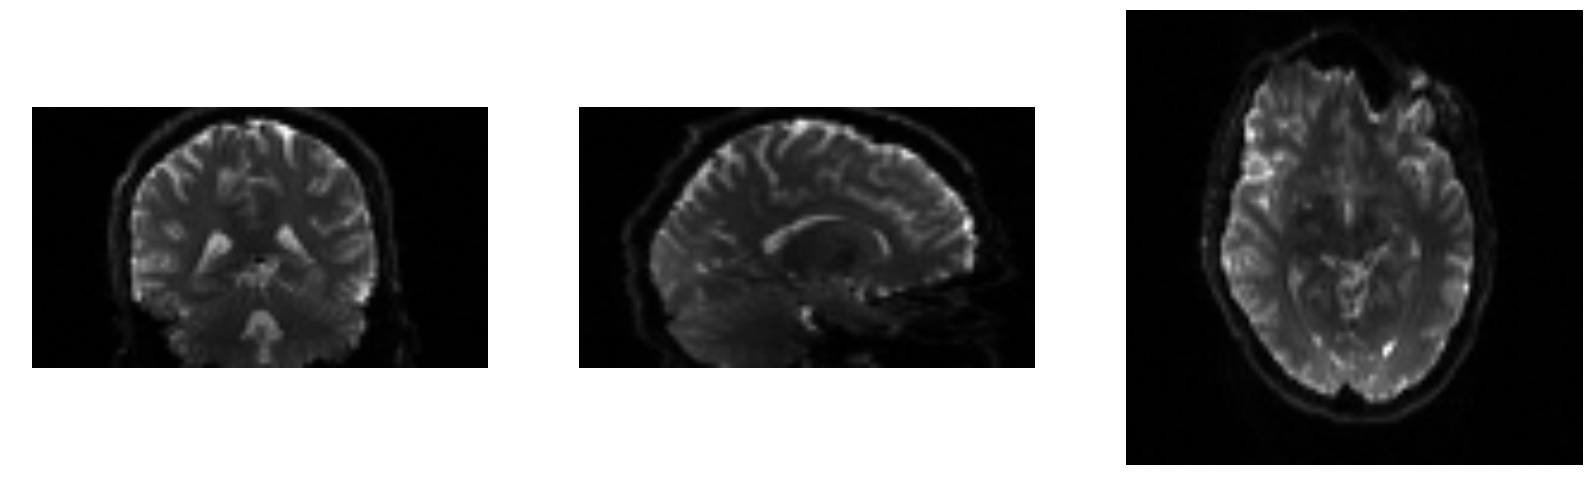

In [8]:
plt.figure
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(data[:, 40, :, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(data[40, :, :, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(data[:, :, 20, 0].T, cmap='gray', origin='lower')
plt.show()


Next load Bval and Bvec files

In [9]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs('NODDI.bval', 'NODDI.bvec')

Use a GradientTable object to hold all the acquisition specific parameters, e.g. b-values, b-vectors. Use function gradient_table to create the object.

In [10]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [11]:
print(gtab.info)

B-values shape (117,)
         min 5.000000 
         max 2000.000000 
B-vectors shape (117, 3)
         min -0.997205 
         max 0.999862 
None


In [12]:
print(gtab.bvals)

[    5.   700.   700.   700.   700.   700.   700.   700.   700.     5.
   700.   700.   700.   700.   700.   700.   700.   700.     5.   700.
   700.   700.   700.   700.   700.   700.   700.     5.   700.   700.
   700.   700.   700.   700.   700.   700.     5.  2000.  2000.  2000.
  2000.  2000.  2000.  2000.  2000.     5.  2000.  2000.  2000.  2000.
  2000.  2000.  2000.  2000.     5.  2000.  2000.  2000.  2000.  2000.
  2000.  2000.  2000.     5.  2000.  2000.  2000.  2000.  2000.  2000.
  2000.  2000.     5.  2000.  2000.  2000.  2000.  2000.  2000.  2000.
  2000.     5.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.
     5.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.     5.
  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.     5.   300.
   300.   300.   300.   300.   300.   300.   300.]


In [13]:
#print the first 10 bvectors (notation is the same as matlib matrix indexing)
print(gtab.bvecs[:10, :])

[[-0.5773502  -0.56513256  0.58931476]
 [ 0.51869565  0.85274225 -0.06152632]
 [ 0.80059832 -0.0819406  -0.59357226]
 [ 0.51508027  0.71643335 -0.47054818]
 [ 0.11831205  0.96070033 -0.25111184]
 [-0.46743399 -0.56365108 -0.68103075]
 [ 0.71663481  0.21114066  0.66472107]
 [ 0.5994221  -0.50575012 -0.62041116]
 [-0.8000164   0.21150333 -0.56146246]
 [-0.5773502  -0.56513256  0.58931476]]


In [14]:
#another way to get the shape of numpy arrays
gtab.bvecs.shape

(117, 3)

### Perform tensor fitting on PETMR dataset

In [98]:
os.chdir('/Users/ShivamDhall/Desktop/Project/Dataset/PETMR_data/')

In [99]:
os.chdir('./Subj1Scan1/')

In [100]:
imgS1S1 = nib.load("NODDI_3Shells.nii.gz")
dataS1S1= imgS1S1.get_data()

In [101]:
dataS1S1.shape

(96, 96, 55, 117)

#### Load the Bvec and Bval files for this particular subject and scan

In [102]:
from dipy.io import read_bvals_bvecs
bvalsS1S1, bvecsS1S1 = read_bvals_bvecs('NODDI.bval', 'NODDI.bvec')

In [103]:
from dipy.core.gradients import gradient_table
gtabS1S1 = gradient_table(bvalsS1S1, bvecsS1S1)

In [104]:
gtabS1S1.bvecs.shape

(117, 3)

### Reconstruct the diffusion signal using a simple tensor model

In [105]:
import dipy.reconst.dti as dti

#### First of all, we mask and crop the data. This is a quick way to avoid calculating Tensors on the background of the image

In [106]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(dataS1S1, 3, 1, True, dilate=2)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)

maskdata.shape (54, 66, 55, 117)


Simple brain extraction tool method for images from DWI data.

It uses a median filter smoothing of the input_volumes vol_idx and an automatic histogram Otsu thresholding technique, hence the name median_otsu.

#### Perform voxel reconstruction

In [107]:
tenmodel = dti.TensorModel(gtabS1S1)

#fitting performed using Weighted least squares by default, but can specify other method
tenfit = tenmodel.fit(maskdata)

In [108]:
print('Computing anisotropy(FA)')
from dipy.reconst.dti import fractional_anisotropy

FA = fractional_anisotropy(tenfit.evals)

Computing anisotropy(FA)


In [109]:
FA[np.isnan(FA)] = 0

In [110]:
FA.shape

(54, 66, 55)

In [111]:
#affine matrix converts voxels coordinates and returns scanner space coordinates
fa_img = nib.Nifti1Image(FA.astype(np.float32), imgS1S1.affine)
nib.save(fa_img, 'tensor_fa.nii.gz')

In [112]:
fa_data = fa_img.get_data()
fa_data.shape

(54, 66, 55)

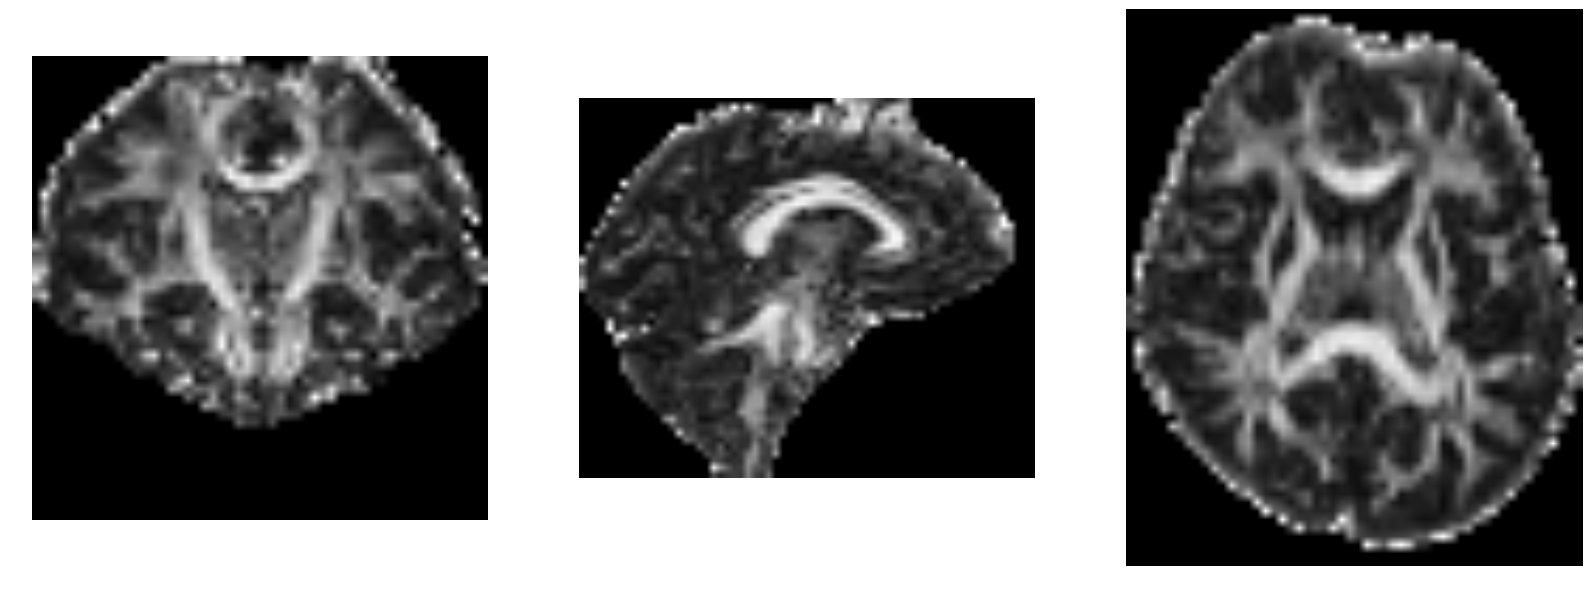

Brighter areas represent regions of higher anisotropic diffusion


In [170]:
plt.figure
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(fa_data[:, 33, :].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(fa_data[29, :, :].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(fa_data[:, :, 35].T, cmap='gray', origin='lower')
plt.show()
print("Brighter areas represent regions of higher anisotropic diffusion")

In [127]:
tenfit.evecs.shape

(54, 66, 55, 3, 3)

In [125]:
from dipy.reconst.dti import color_fa
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)
RGB_img = nib.Nifti1Image(np.array(255 * RGB, 'uint8'), imgS1S1.affine)
nib.save(RGB_img, 'tensor_rgb.nii.gz')

In [128]:
RGB_data = RGB_img.get_data()
RGB_data.shape
RGB_data[:, 20, 35, 2]

array([  0,   0,   0,  13, 134,  32,   7,   1,  10,   3,   5,  15,  32,
        36, 100,  80,  17,  23,   9,  15,  29,  12,  19,  16,  22,  74,
        41,   6,  15,  20,  66, 125, 104,  95,  48,  27, 113, 122,  46,
        13, 172,  87,   0,   5,   4,  13,  19,  17,  22,   9,  13,  43,
        13,   0], dtype=uint8)

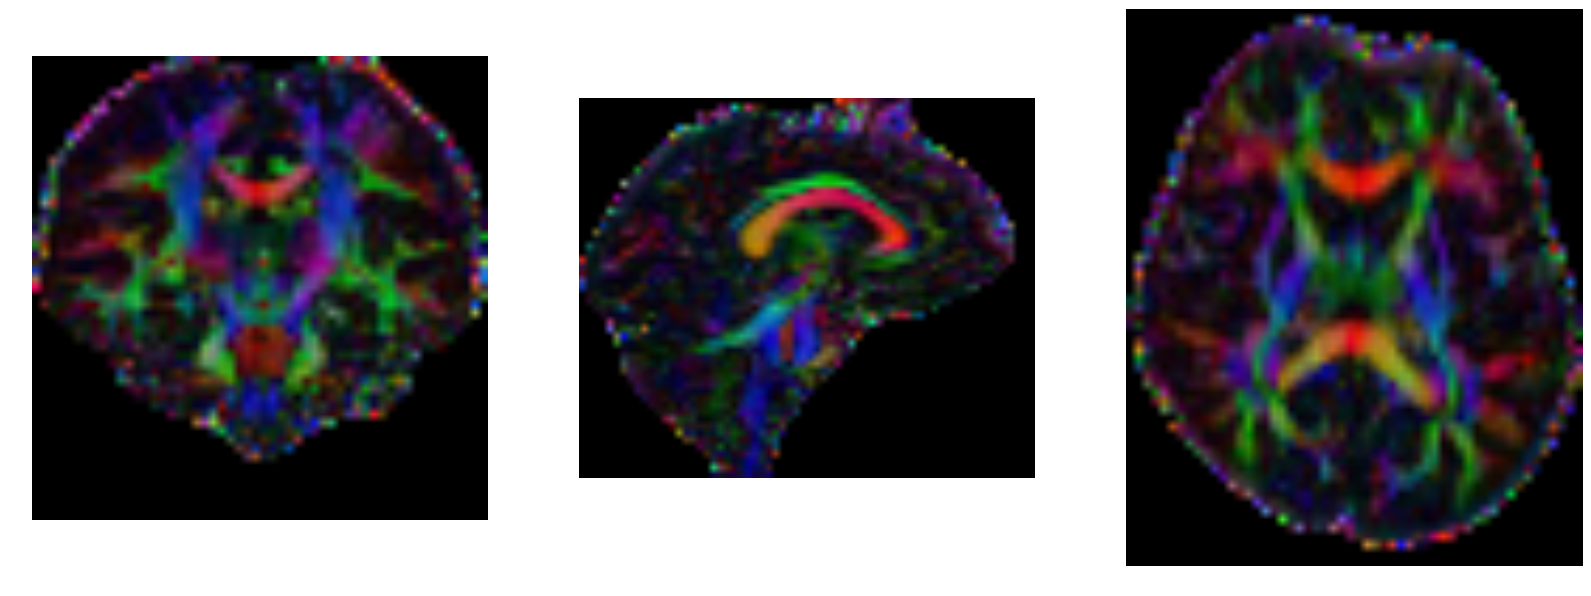

Color Fractional Anisotropy Map


In [169]:
plt.figure
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(RGB_data[:, 30, :, :].transpose(1,0,2), origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(RGB_data[29, :, :, :].transpose(1,0,2), origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(RGB_data[:, :, 35, :].transpose(1,0,2), origin='lower')
plt.show()
print("Color Fractional Anisotropy Map")

## Perform tensor fitting on TRIO dataset

In [57]:
os.chdir('/Users/ShivamDhall/Desktop/Project/Dataset/TRIO_data/Subj1Scan1/')

In [60]:
imgS1S1_2 = nib.load("NODDI_3Shells.nii.gz")
dataS1S1_2 = imgS1S1_2.get_data()
dataS1S1_2.shape

(96, 96, 55, 117)

In [63]:
from dipy.io import read_bvals_bvecs
bvalsS1S1_2, bvecsS1S1_2 = read_bvals_bvecs('NODDI.bval', 'NODDI.bvec')

from dipy.core.gradients import gradient_table
gtabS1S1_2 = gradient_table(bvalsS1S1_2, bvecsS1S1_2)

In [66]:
import dipy.reconst.dti as dti

from dipy.segment.mask import median_otsu
maskdata2, mask2 = median_otsu(dataS1S1_2, 3, 1, True, dilate=2)
print('maskdata2.shape (%d, %d, %d, %d)' % maskdata2.shape)

maskdata2.shape (58, 66, 54, 117)


#### Fit tensor model to data

In [67]:
tenmodel2 = dti.TensorModel(gtabS1S1_2)

#fitting performed using Weighted least squares by default, but can specify other method
tenfit2 = tenmodel2.fit(maskdata2)

In [68]:
print('Computing anisotropy(FA)')
from dipy.reconst.dti import fractional_anisotropy

FA2 = fractional_anisotropy(tenfit2.evals)
FA2[np.isnan(FA2)] = 0

Computing anisotropy(FA)


In [69]:
#affine matrix converts voxels coordinates and returns scanner space coordinates
fa_img2 = nib.Nifti1Image(FA2.astype(np.float32), imgS1S1_2.affine)
nib.save(fa_img2, 'tensor_fa.nii.gz')

In [70]:
fa_data2 = fa_img2.get_data()
fa_data2.shape

(58, 66, 54)

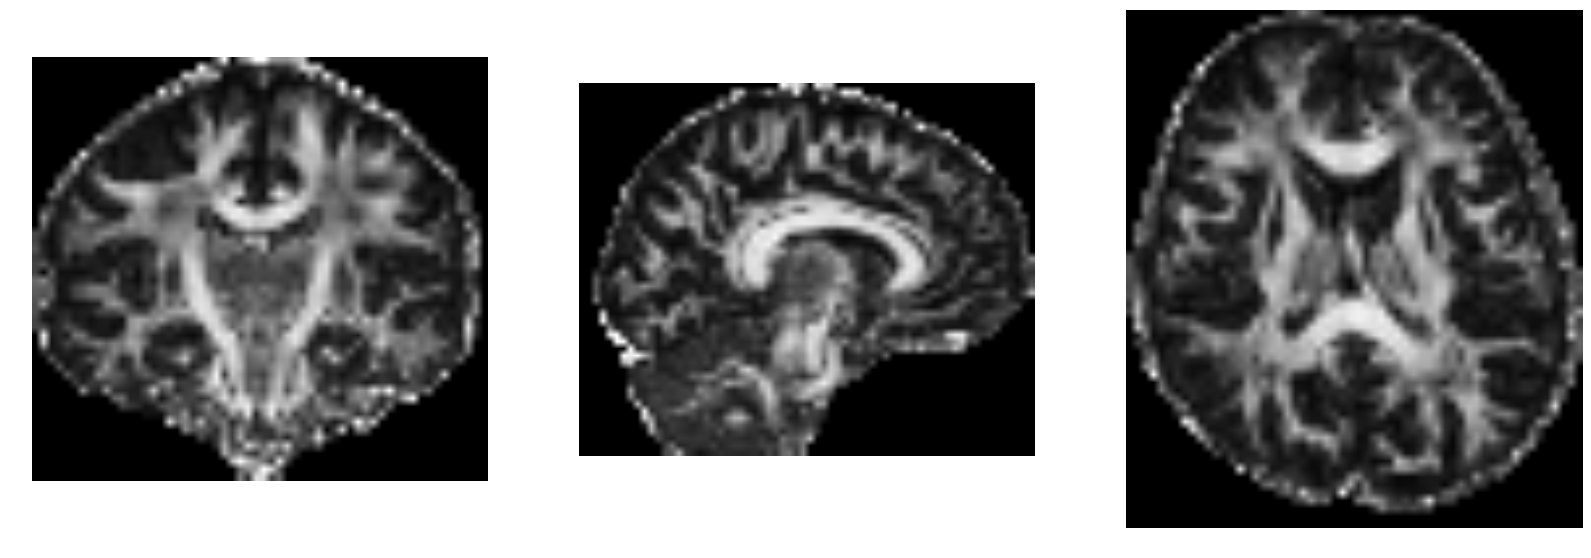

Brighter areas represent regions of higher anisotropic diffusion


In [171]:
plt.figure
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(fa_data2[:, 33, :].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(fa_data2[25, :, :].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(fa_data2[:, :, 29].T, cmap='gray', origin='lower')
plt.show()
print("Brighter areas represent regions of higher anisotropic diffusion")

In [75]:
from dipy.reconst.dti import color_fa
FA2 = np.clip(FA2, 0, 1)
RGB2 = color_fa(FA2, tenfit2.evecs)
RGB_img2 = nib.Nifti1Image(np.array(255 * RGB2, 'uint8'), imgS1S1_2.affine)
nib.save(RGB_img2, 'tensor_rgb.nii.gz')

In [87]:
RGB_data2 = RGB_img2.get_data()
RGB_data2.shape

(58, 66, 54, 3)

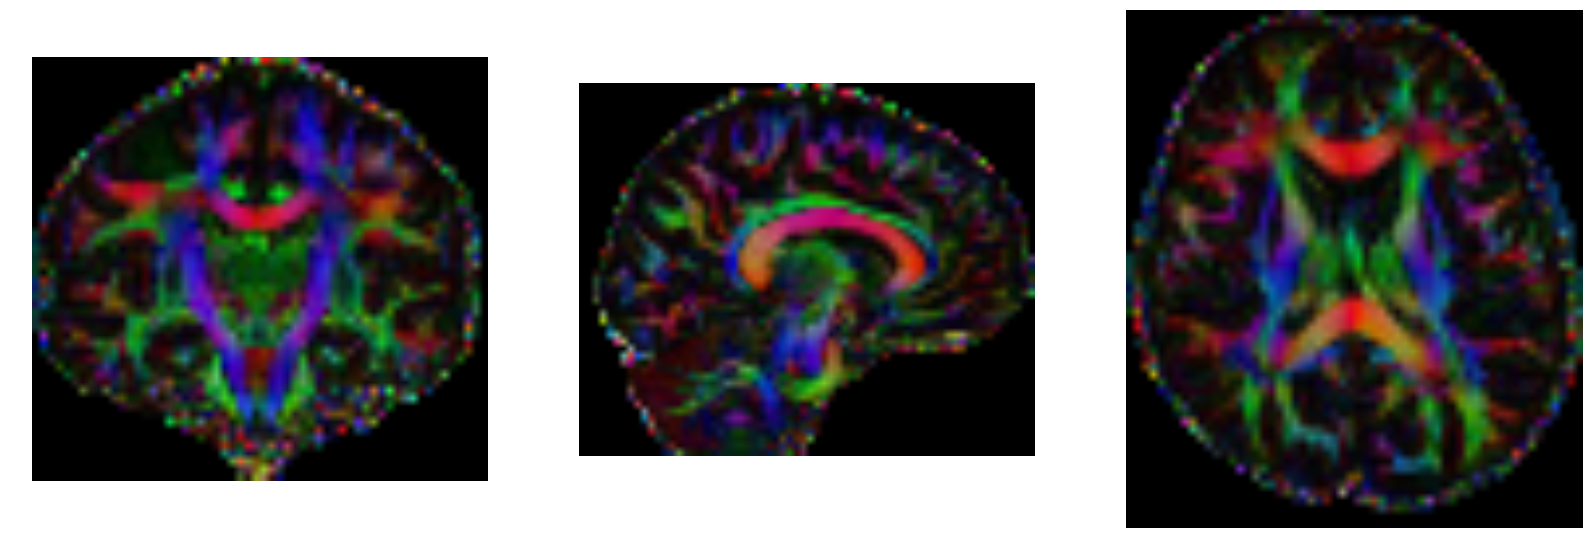

Color Fractional Anisotropy Map


In [178]:
plt.figure
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(RGB_data2[:, 33, :, :].transpose(1,0,2), origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(RGB_data2[25, :, :, :].transpose(1,0,2), origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(RGB_data2[:, :, 29, :].transpose(1,0,2), origin='lower')
plt.show()
print("Color Fractional Anisotropy Map")